In [14]:
import numpy as np
import pandas as pd
import joblib
import datetime
import matplotlib.pyplot as plt
from hyperopt import hp, Trials, STATUS_OK, fmin, anneal
from functools import partial
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [15]:
# Load the datasets
train_df = pd.read_excel("train_data.xlsx")
test_df = pd.read_excel("test_data.xlsx")

In [16]:
# Define feature matrix and target variable
X_train = train_df.drop(['P'], axis=1)
y_train = train_df['P']
X_test = test_df.drop(['P'], axis=1)
y_test = test_df['P']

In [17]:
# Define Model Evaluation Metric
def model_metrics(model, X, y):
    """Evaluate model performance using RMSE."""
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y, y_pred))

In [18]:

# Bayesian Optimization Function
def bayes_fmin(X_train, X_test, y_train, y_test, eval_iters=100):
    """Optimize hyperparameters using Bayesian optimization."""

    def objective(params):
        model = GradientBoostingRegressor(
            learning_rate=float(params['learning_rate']),
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            max_features=int(params['max_features']),
            random_state=42
        )
        model.fit(X_train, y_train)
        loss = model_metrics(model, X_test, y_test)

        with open('./GBR-Bayesian-fitness-RMSE.txt', 'a+') as f:
            f.write(f"{loss}\n")

        return {"loss": loss, "status": STATUS_OK}

    space = {
        'n_estimators': hp.quniform('n_estimators', 1, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 50, 1),
        'learning_rate': hp.quniform('learning_rate', 0.0001, 1, 0.01),
        'max_features': hp.quniform('max_features', 1, 11, 1)
    }

    best_params = fmin(
        fn=objective,
        space=space,
        algo=partial(anneal.suggest),
        max_evals=eval_iters,
        trials=Trials(),
        return_argmin=True
    )

    return {k: int(v) if k != 'learning_rate' else float(v) for k, v in best_params.items()}

In [19]:
# Optimize Parameters
best_params = bayes_fmin(X_train, X_test, y_train, y_test, 500)
print("Optimized Parameters:", best_params)

# Train Final Model
gbr_reg = GradientBoostingRegressor(**best_params, random_state=42)
gbr_reg.fit(X_train, y_train)
y_train_pred, y_test_pred = gbr_reg.predict(X_train), gbr_reg.predict(X_test)

# Evaluate Model
metrics = {
    "Train RMSE": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "Train MAE": mean_absolute_error(y_train, y_train_pred),
    "Train R2": r2_score(y_train, y_train_pred),
    "Test RMSE": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "Test MAE": mean_absolute_error(y_test, y_test_pred),
    "Test R2": r2_score(y_test, y_test_pred)
}

for metric, value in metrics.items():
    print(f"INFO: {metric} = {value:.2f}")




100%|██████████| 500/500 [08:35<00:00,  1.03s/trial, best loss: 16.65088777583876]
Optimized Parameters: {'learning_rate': 0.04, 'max_depth': 6, 'max_features': 4, 'n_estimators': 200}
INFO: Train RMSE = 3.78
INFO: Train MAE = 2.72
INFO: Train R2 = 1.00
INFO: Test RMSE = 16.65
INFO: Test MAE = 7.15
INFO: Test R2 = 0.99


In [20]:
def compute_bic(model, X, y):
    """Compute Bayesian Information Criterion (BIC) for a regression model."""
    n = X.shape[0]
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)

    # Approximate number of parameters:
    n_estimators = model.get_params()['n_estimators']
    max_depth = model.get_params()['max_depth']
    k = n_estimators * max_depth  # Rough approximation for tree models

    bic = n * np.log(rss / n) + k * np.log(n)
    return bic


In [21]:
bic_train = compute_bic(gbr_reg, X_train, y_train)
bic_test = compute_bic(gbr_reg, X_test, y_test)

print(f"BIC (Train): {bic_train:.2f}")
print(f"BIC (Test): {bic_test:.2f}")


BIC (Train): 17893.32
BIC (Test): 16106.15


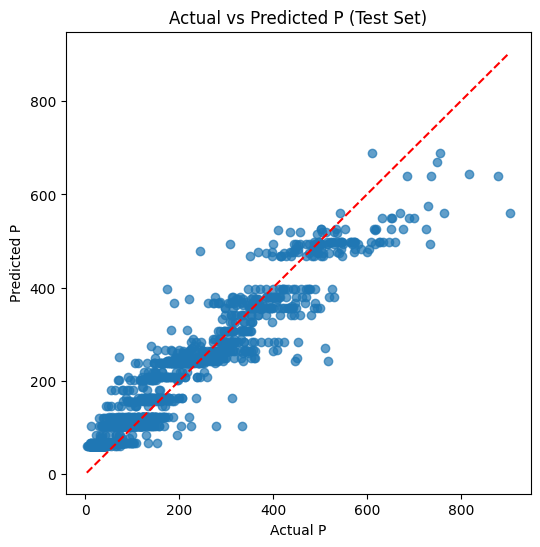

In [23]:
# Scatter plot of True vs Predicted values for Test set
plt.figure(figsize=(6, 6))
plt.scatter(y_test, model.predict(X_test), alpha=0.7)
plt.xlabel("Actual P")
plt.ylabel("Predicted P")
plt.title("Actual vs Predicted P (Test Set)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # 1:1 line
plt.show()

Save the trained  model to a file using joblib.



In [24]:
joblib.dump(model, 'gradientboost_model.pkl')

['gradientboost_model.pkl']

:
Calculate the residuals, create a residual plot, and create a histogram of the residuals to evaluate the model's performance on the test set.



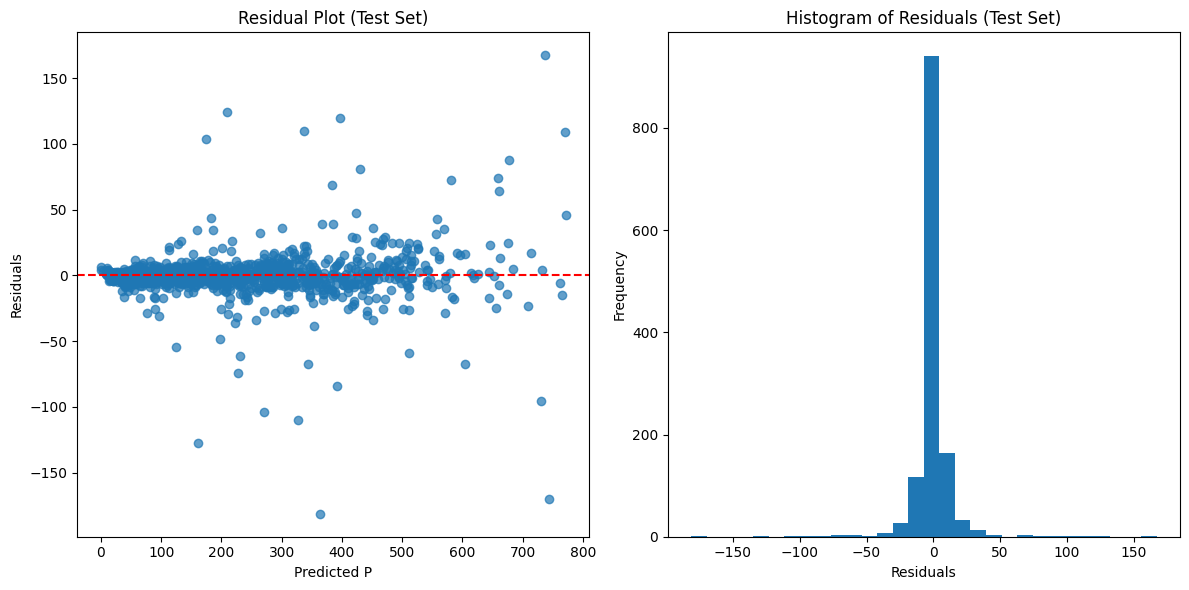

In [25]:
# Calculate residuals
residuals = y_test - y_test_pred

# Create residual plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.7)
plt.xlabel("Predicted P")
plt.ylabel("Residuals")
plt.title("Residual Plot (Test Set)")
plt.axhline(y=0, color='r', linestyle='--')

# Create histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals (Test Set)")

plt.tight_layout()
plt.show()

## Predict on new data


Create some sample new data and use the trained model to make predictions.


**Reasoning**:
Create sample new data and use the trained model to make predictions.



In [27]:
# Create sample new data
new_data = pd.DataFrame({
    'FH': [15.0, 18.0, 12.0],
    'DT': [0.5, 1.0, 0.3],
    'EH': [10.0, 15.0, 8.0],
    'LT': [2.5, 3.0, 2.0],
    'CD': [6.0, 7.0, 5.0],
    'TC': [30.0, 40.0, 25.0],
    'MT': [500.0, 700.0, 300.0]
})



In [33]:
# Predict on new data
new_predictions = model.predict(new_data)

# Print the predicted values
print("Predicted P for new data:")
print(new_predictions)

Predicted P for new data:
[123.28349183 163.27758621  66.80517413]


## Summary:

### Data Analysis Key Findings

*   The trained AdaBoost model was successfully saved to a file named `gradientboost_model.pkl`.
*   Residual plots and histograms of residuals were generated to visually evaluate the model's performance on the test set.
*   The trained model was used to predict the target variable 'P' on a sample of new data, and the predicted values were displayed.

### Way forward

*   Analyzing the residual plot and histogram of residuals can provide insights into the model's error distribution and potential areas for improvement.
*   The ability to save and load the model allows for its deployment and use on new, unseen data.
